# Mode-Turbulence Coupling: Numerical Analysis
# determine dTau

In [1]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

import random
import matplotlib.pyplot as plt
import numpy as np
import math
import scipy.interpolate as interpolate

n_bins = 200

axis_font = {'size':'30'}
title_font = {'size':'40'}

# flattens nested arrays into one dimensional arrays
def flatten(input):
    new_list = []
    for i in input:
        for j in i:
            new_list.append(j)
    return new_list

## Physical Parameters

In [2]:
# mach number Ma
Ma = 0.025 ** (1/2)
K = 1
eta = 1

## Functions of Ma

In [3]:
meandeltaT = 2 * np.pi

# variables for generating F1
stdF1 = eta * Ma**2 / (2 * np.pi)
limitY1 = eta / (2 * np.pi)

# variables for generating F2 and G1
stdF2 = eta * Ma**2
limitY2 = eta 

## Calculation parameters

In [4]:
L = 1
M = 10**3
M_short = 200
N = 1
m = 10**2


# dTau is the time step for Huen's Method
def fundTau(J): 
    dTau= 2 * np.pi / J
    return dTau

# start with J = 100 and multiply by a factor of 2
J_initial = 400
J = J_initial

Tr = K * meandeltaT

## Calculation relations

In [5]:
 Tmax = 2 * np.pi * M
# delt = N * deltaT

## Initial Conditions

In [6]:
initial_dAdT = 0
initial_AT = 0

### Time Functions

In [7]:
# deltaT is the length of each eddy turnover
def fundeltaT(n_bins, M, dTau):
    deltaT = []
    
    # generate a rayleigh distribution from which to pick values for deltaT from
    rayleigh = np.random.rayleigh(meandeltaT, M)                           
    hist, bin_edges = np.histogram(rayleigh, bins=n_bins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    
    for i in range(M):
        # picks a random value from the rayleigh distribution
        r = np.random.rand(1)
        deltaTtemp = inv_cdf(r)
        
        # rounds deltaTtemp up or down to be an interger multiple of dTau
        if (deltaTtemp % dTau < 0.005):
            deltaTtemp2 = deltaTtemp - (deltaTtemp % dTau)
        else:
            deltaTtemp2 = deltaTtemp + dTau - (deltaTtemp % dTau)
        deltaT.append(deltaTtemp2)
    
    # plots deltaT distribution  
    deltaT = flatten(deltaT)
    count, bins, ignored = plt.hist(deltaT, 80, density=True)
    plt.title("Delta T")
    plt.xlabel("Delta T")
    plt.show()
    
    return deltaT

# Tturb adds up the delta T's
def funTturb(deltaT):
    Tturb=[0]
    for i in range(len(deltaT)-1):
        Tturb.append(deltaT[i]+Tturb[i])
    Tturb.pop(-1)
    return Tturb

### F_k Function

In [8]:
# generating F1, F2, G1
def funF_k(std, limit, deltaT, Tturb):
    F_k =[]
    time = []
    y1 = 0
    for i in range(len(deltaT) - 1):
        
        # Tn is halfway through the eddy
        Tn = ((deltaT[i] + deltaT[i+1]) / 2)
        
        stdevt = ((1 - math.exp(-2 * Tn / Tr)) * std ** 2) ** (1/2)
        meant = math.exp(-Tn / Tr) * y1
        
        # y1 is chosen from markov conditional probability function
        # put limit on y1
            # set y1 > limitY1 so that while loop only ends when y1 < limitY1
        y1 = limit + 1
        while abs(y1) > limit:
            y1 = np.random.normal(meant, stdevt, 2)[0]
        
        # loops through each eddy
        for j in np.linspace(0, deltaT[i], deltaT[i] / dTau):
            x = j / deltaT[i]
            if j == deltaT[i]:
                pass
            else:
                time.append(j + Tturb[i])
                F_k.append(16 * y1 * x**2 * (1 - x)**2)
        
    return F_k, time

### Plotting Functions

In [9]:
def Funplots(t, g1, f1, f2):

    plt.figure(figsize=(40,10))    
    plt.plot(t, f1, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2081', **axis_font)
    plt.tight_layout()
    plt.show()
    
    plt.figure(figsize=(40,10))
    plt.plot(t, g1, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('G\u2081', **axis_font)
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(40,10))
    plt.plot(t, f2, 'k')
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('F\u2082', **axis_font)
    plt.tight_layout()
    plt.show()
    
def FunHist(F1, F2, G1):
    plt.hist(F1, 20)
    plt.title("F1")
    plt.show()
    
    plt.hist(G1, 20)
    plt.title("G1")
    plt.show()
    
    plt.hist(F2, 20)
    plt.title("F2")
    plt.show()

### Huen's method

In [10]:
def funAmp(F1, F2, G1, dTau):
    # huen's method
    
    A = initial_AT
    Amp = [A]
    t = 0.0
    amptime = [t]
    u = 0
    ratio = int(dTau / fundTau(J_initial))
    
    for i in range(0, int(len(F1) / ratio) -2):
        m1 = u
        k1 = -( F1[i * ratio] * u ) - ( 1 + G1[i * ratio] ) * A + F2[i * ratio]
        m2 = u + dTau * k1
        A_2 = A + dTau * m1
        u_2 = m2
        k2 = -( F1[i * ratio +1] * u_2 ) - ( 1 + G1[i  * ratio + 1] ) * A_2 + F2[i * ratio + 1]
        m2 = u + dTau * k2
        t = t + dTau
        A = A + (dTau / 2) * (m1 + m2)
        u = u + (dTau / 2) * (k1 + k2)
        Amp.append(A)
        amptime.append(t)

    Amp = Amp[:-1]
    amptime = amptime[:-1]
    
    return Amp, amptime

# Evolutions

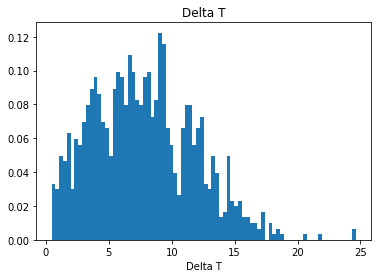

In [11]:
dTau = fundTau(J)

# deltaT is the length of each eddy turnover
deltaT = fundeltaT(n_bins, M, dTau)

# Tturb is the consecutive sum of deltaT's so each value marks a new eddy
Tturb = funTturb(deltaT)

/Users/celiatandon/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:22: DeprecationWarning: object of type <class 'numpy.float64'> cannot be safely interpreted as an integer.


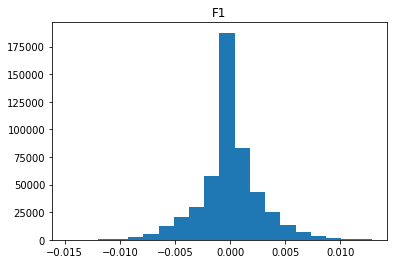

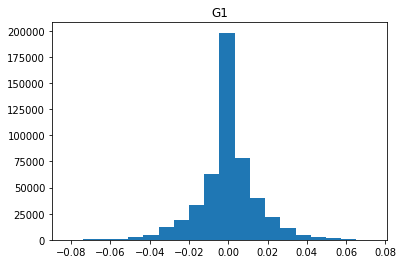

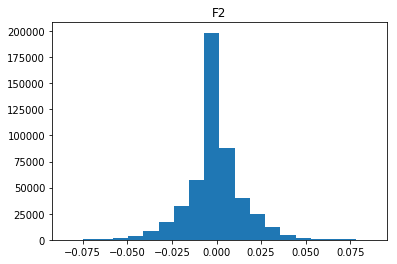

long run:


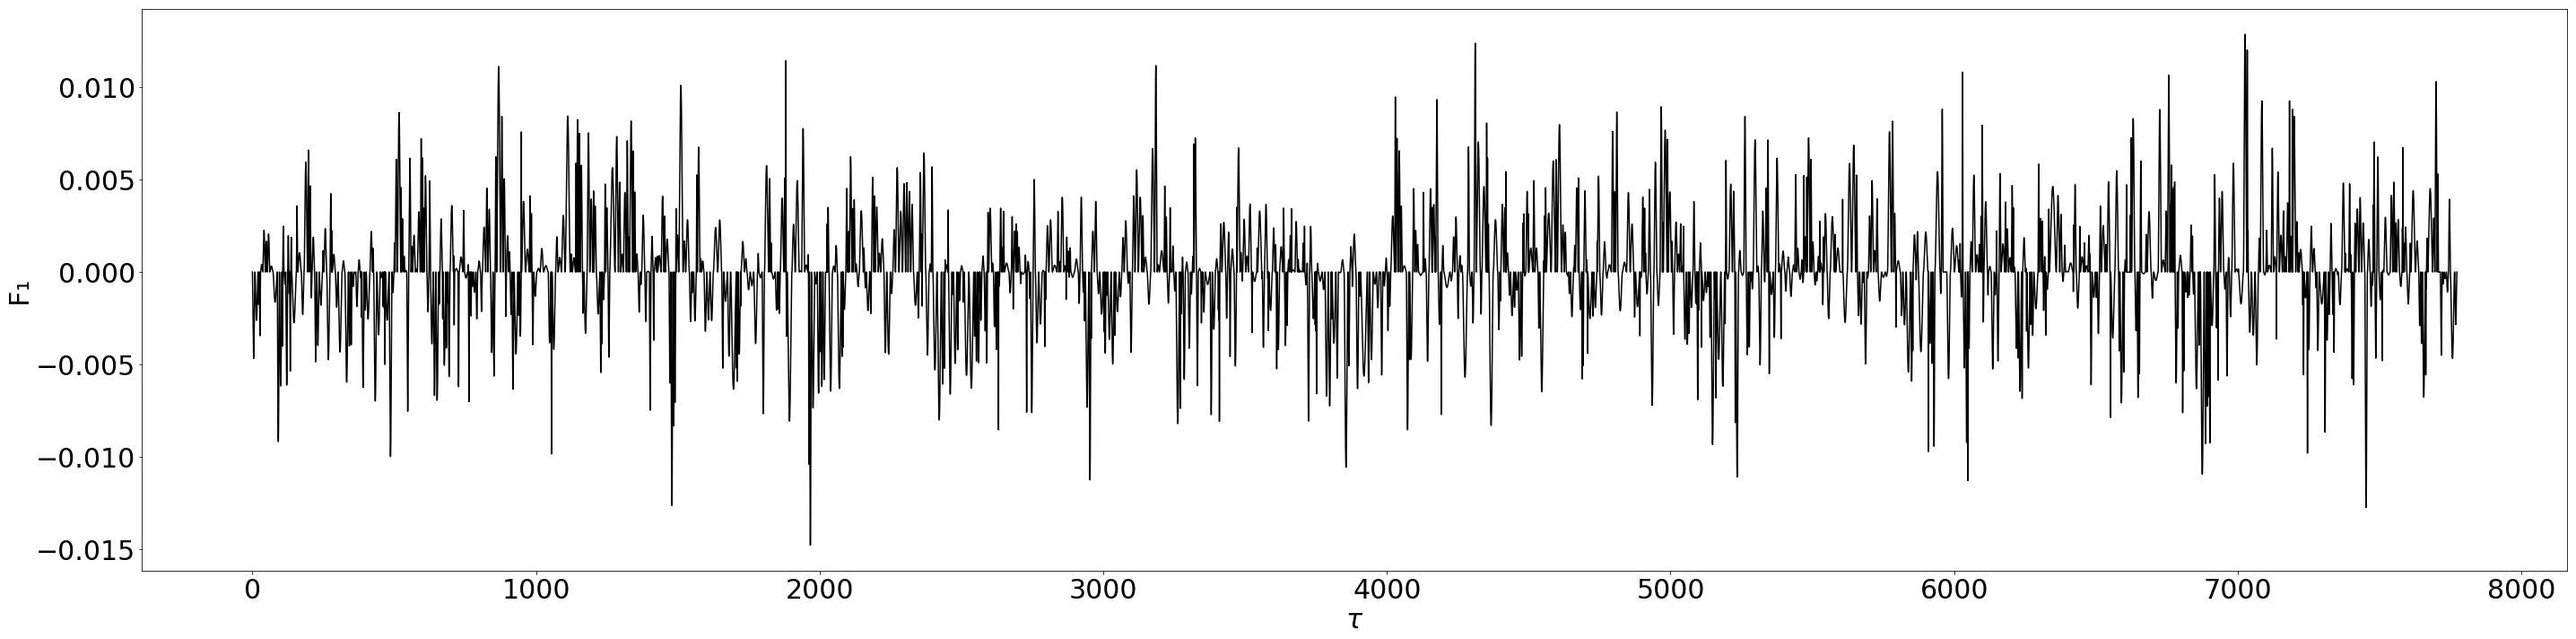

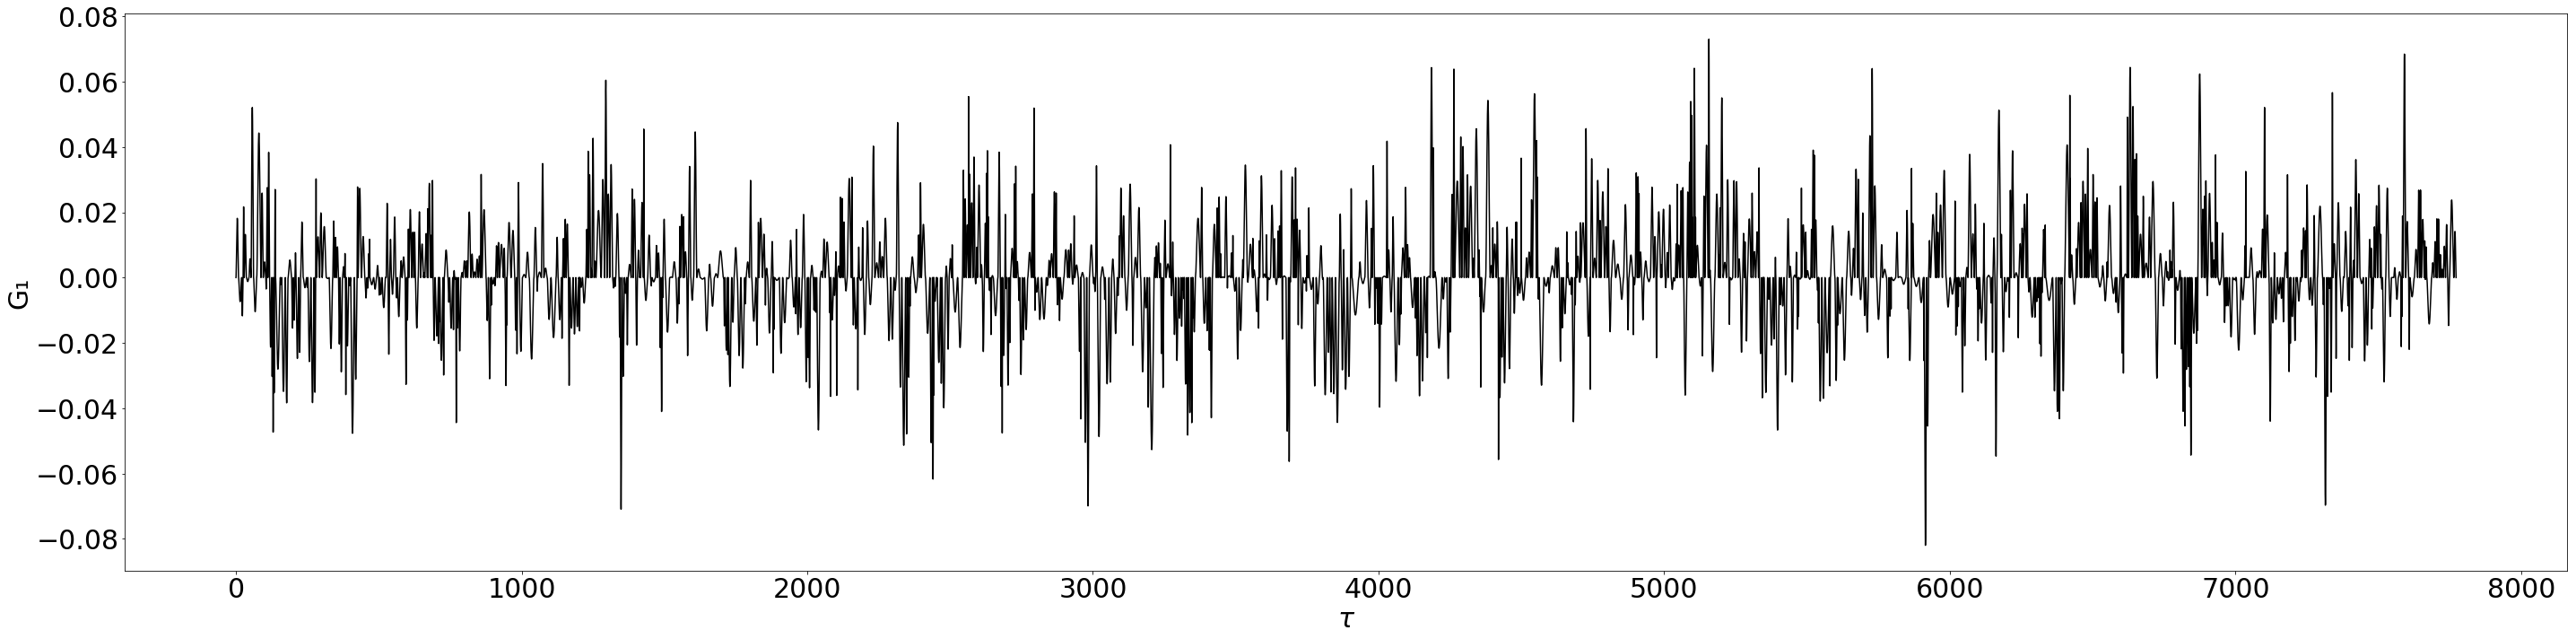

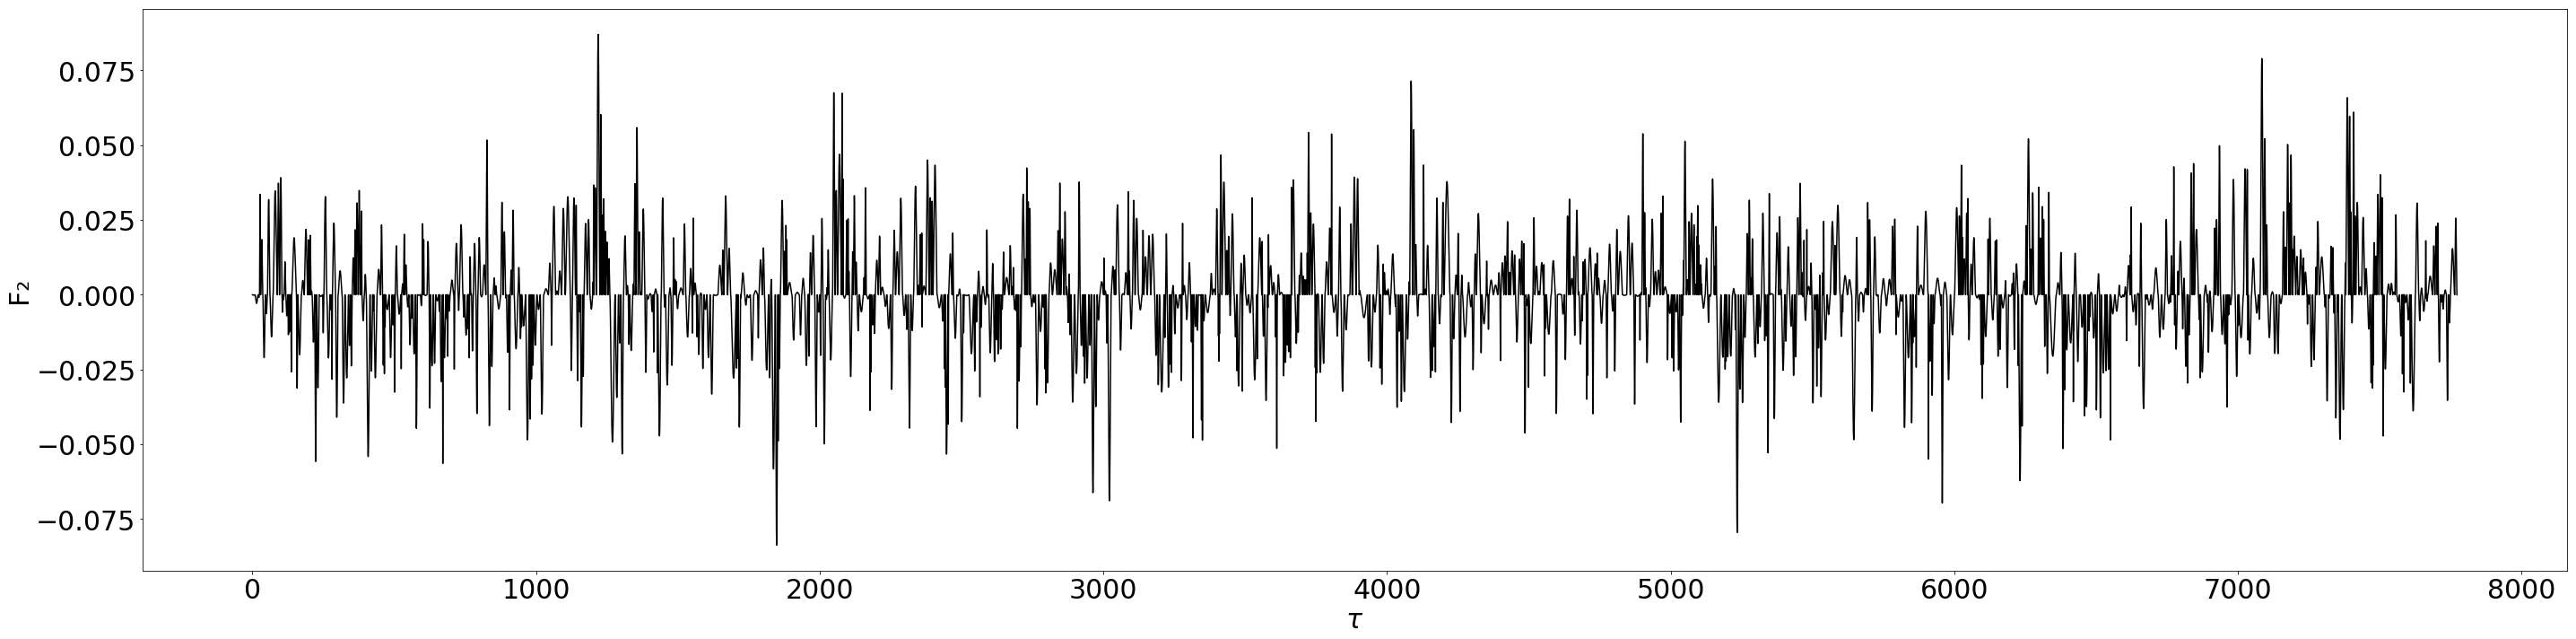

short run:


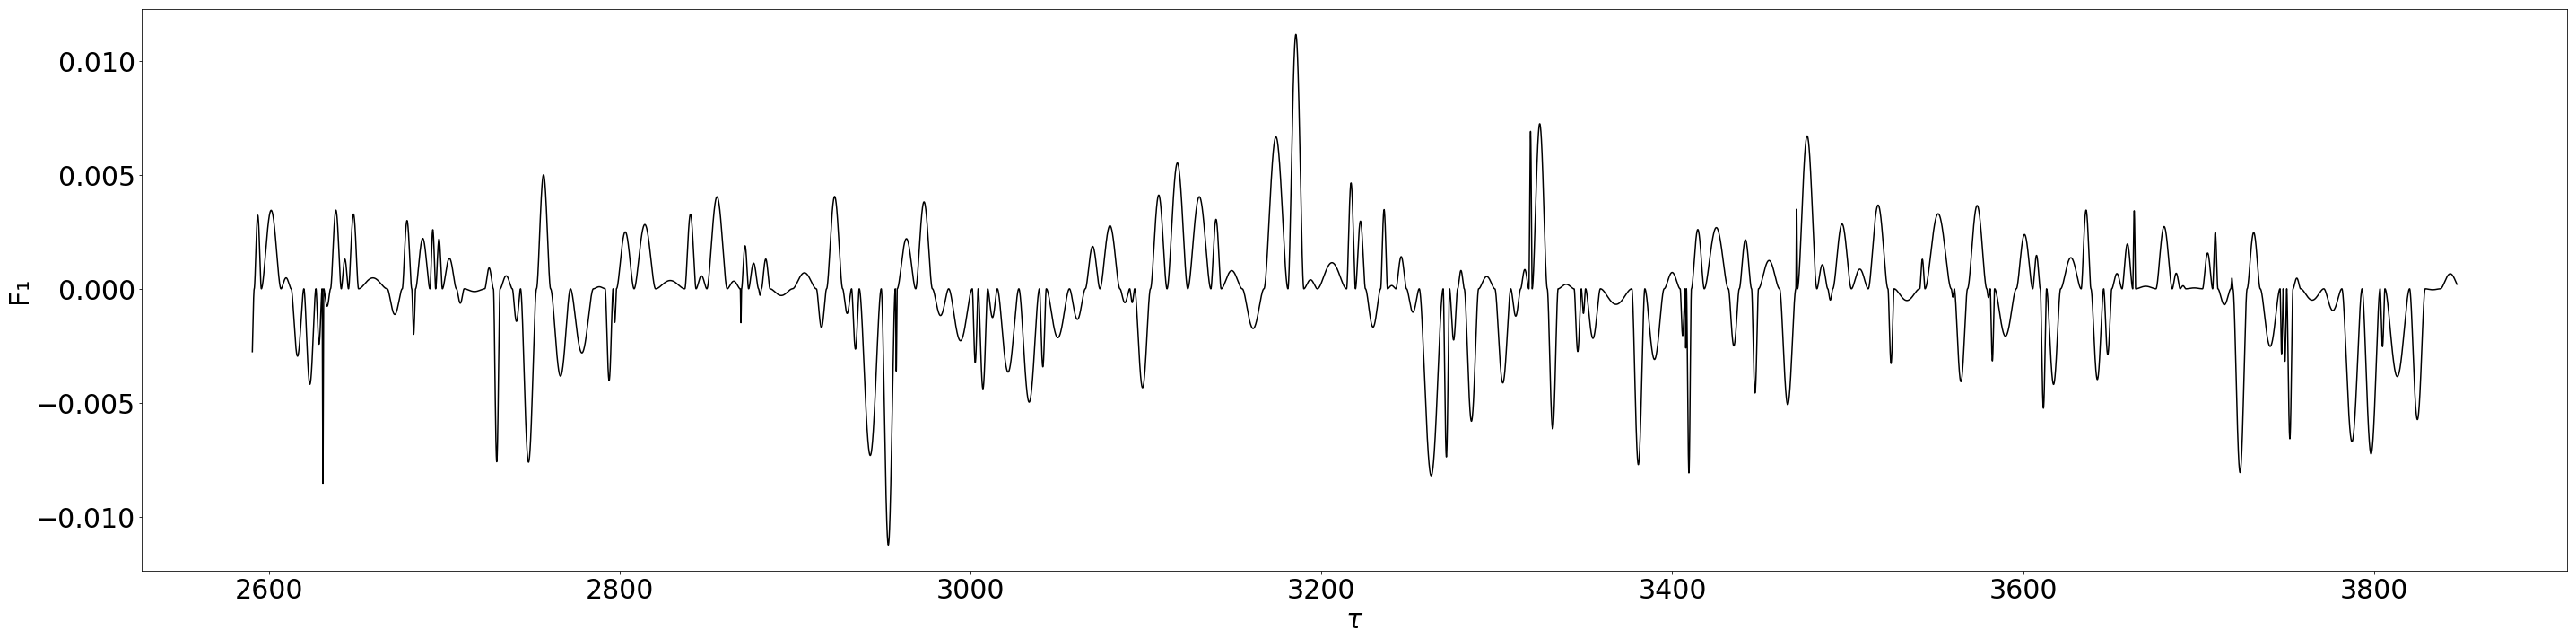

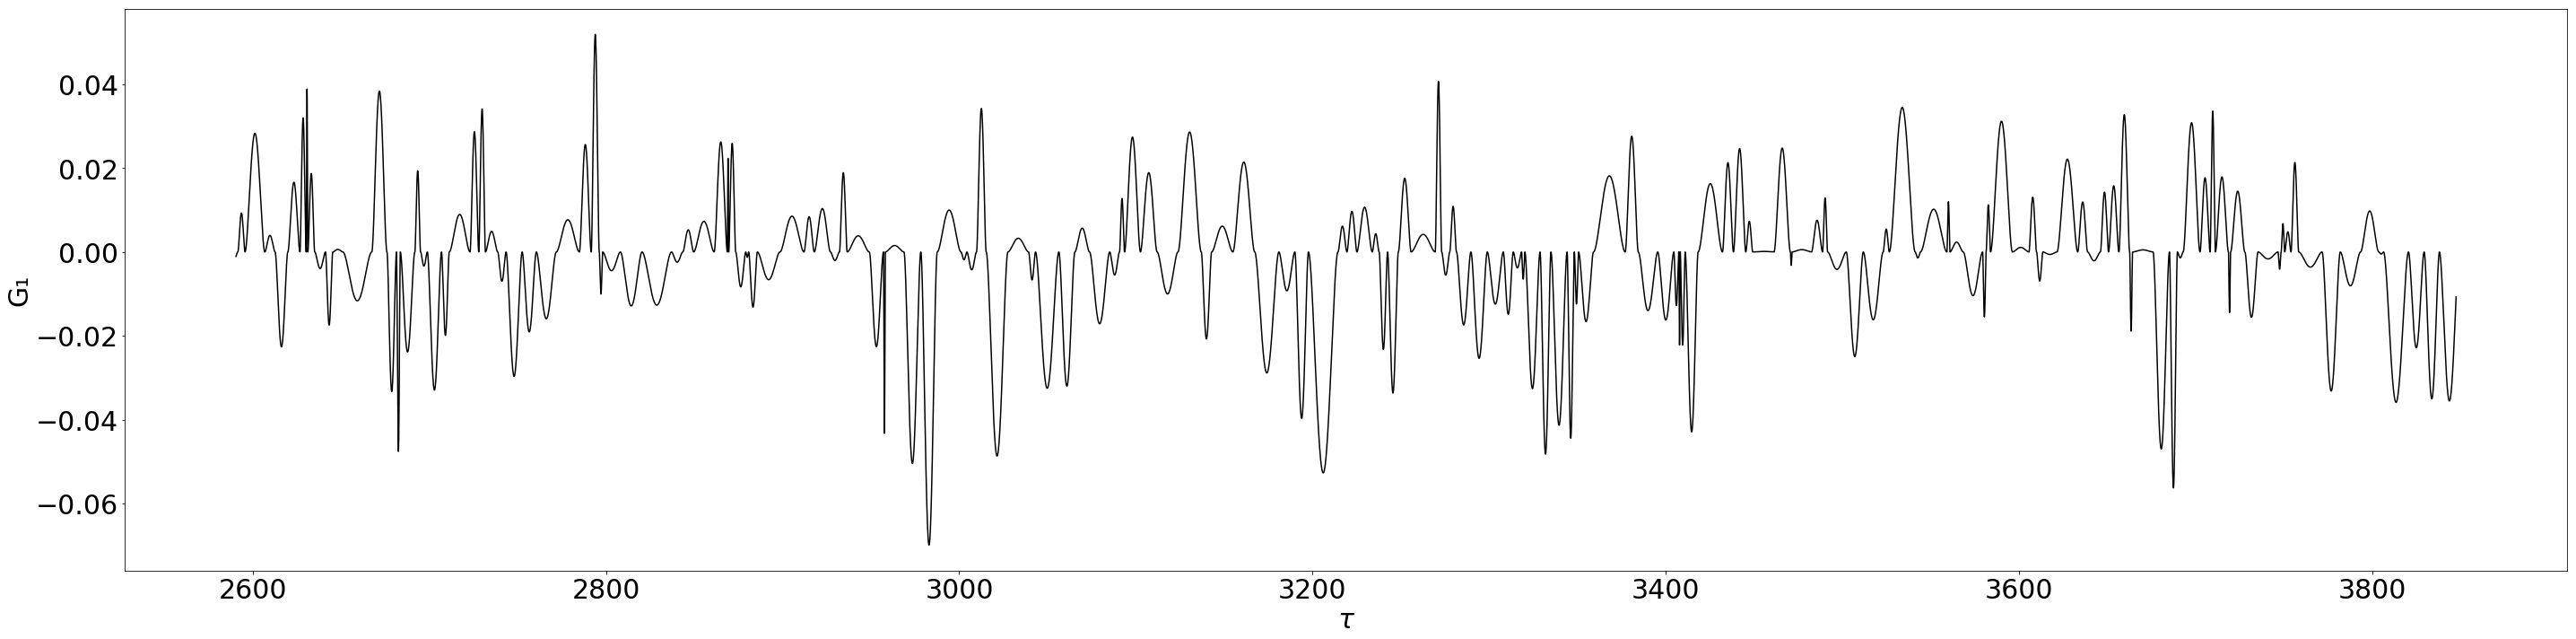

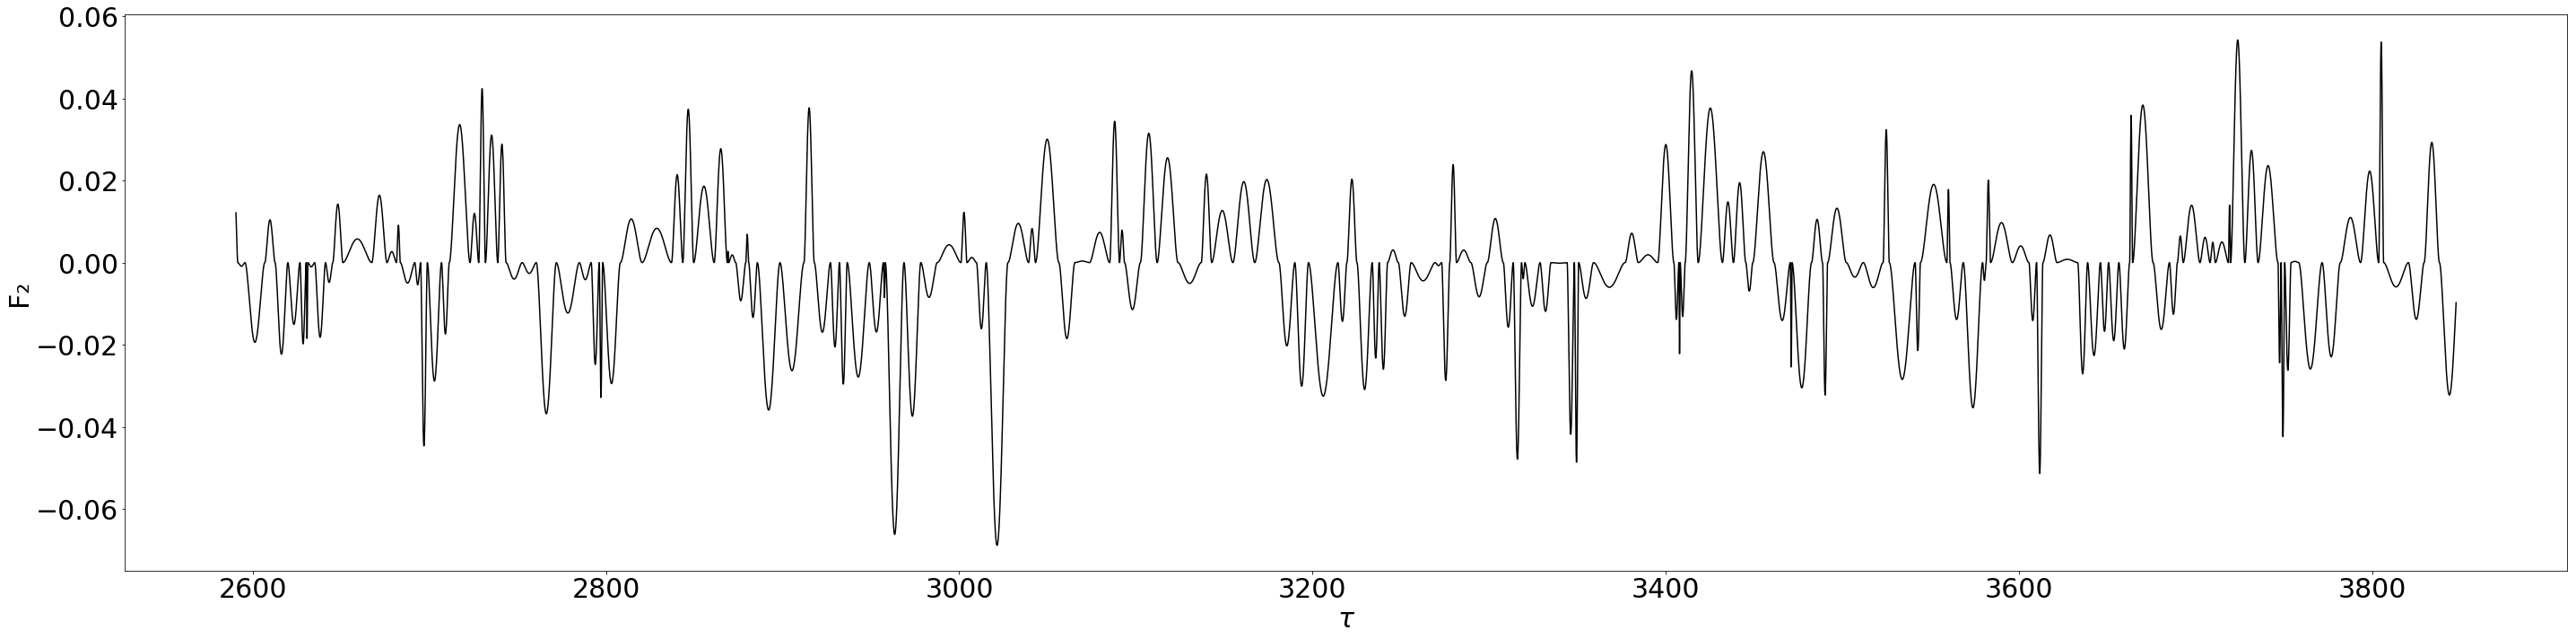

In [12]:
# generate F1
F1, time = funF_k(stdF1, limitY1, deltaT, Tturb)

# generate F2
F2, time = funF_k(stdF2, limitY2, deltaT, Tturb)

# generate G1
G1, time = funF_k(stdF2, limitY2, deltaT, Tturb)

FunHist(F1, F2, G1)

# plot all plots 
print ("long run:")
    
Funplots(time, G1, F1, F2)

# plot the shorter plot
duration = 2 * np.pi * M_short
tshort = []
f1short = []
f2short = []
g1short = []

# start the shorter plot a third of the way through the run
start_index = int(len(time)/3)
index = start_index
while time[index] < (duration + time[start_index]):
    tshort.append(time[index])
    f1short.append(F1[index])
    f2short.append(F2[index])
    g1short.append(G1[index])
    index +=1
    
# plot all plots
print ("short run:")
    
Funplots(tshort, g1short, f1short, f2short)

dTau = 2 * pi / 400


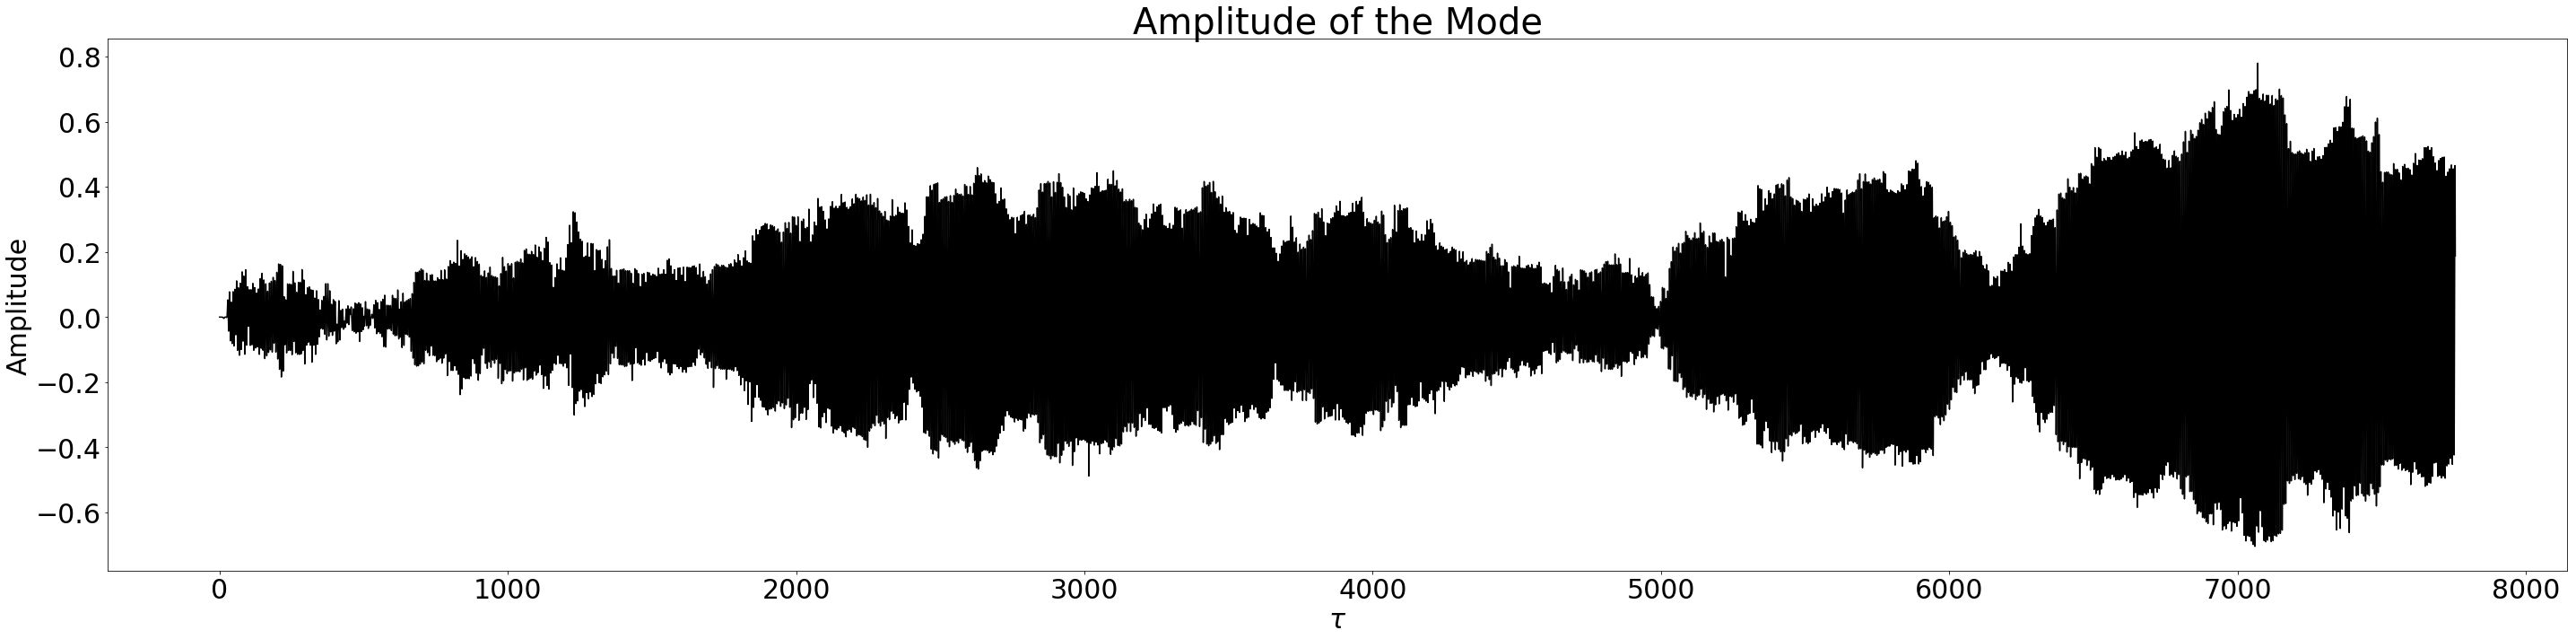

dTau = 2 * pi / 200.0


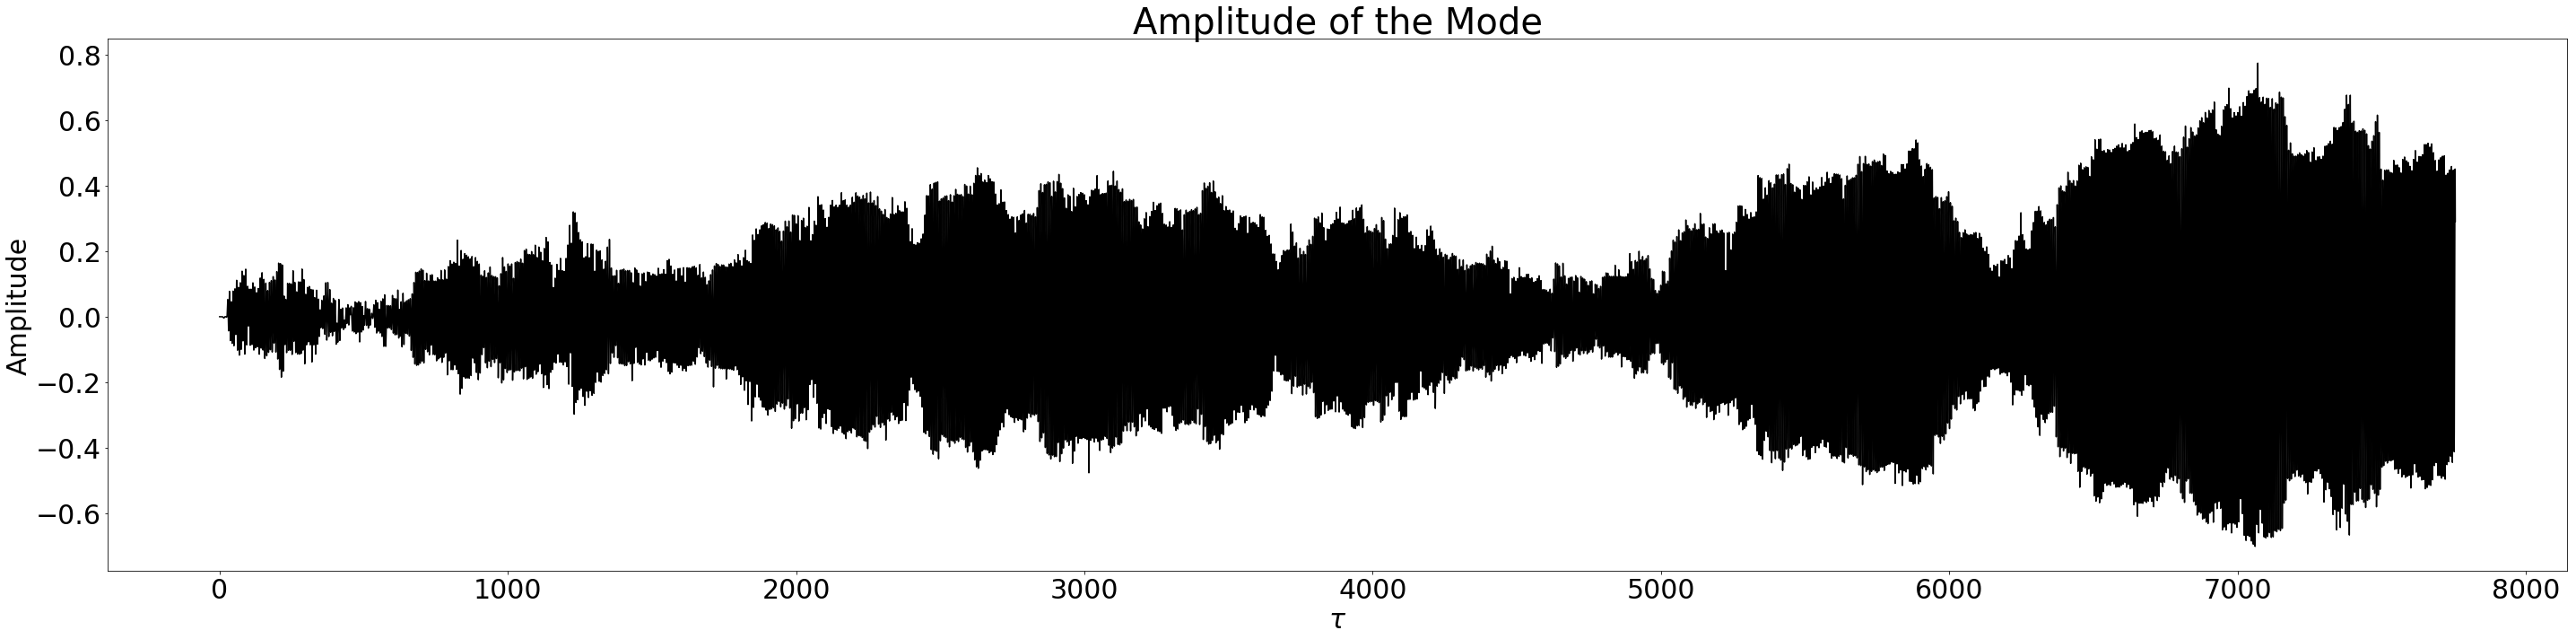

dTau = 2 * pi / 100.0


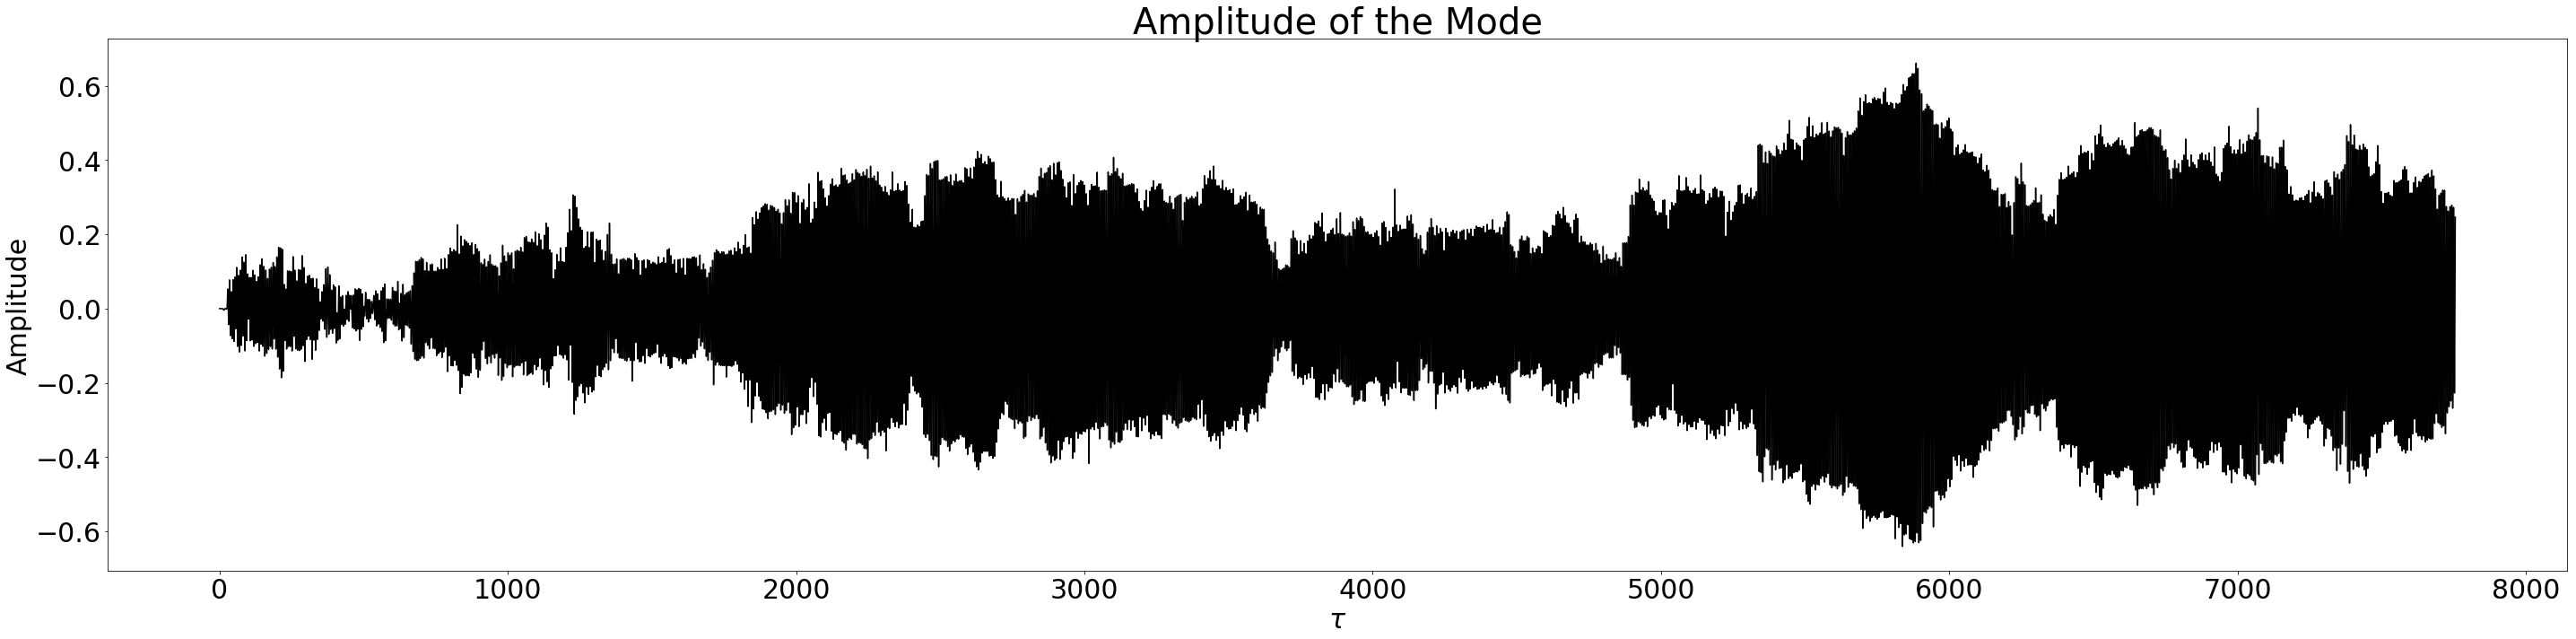

dTau = 2 * pi / 50.0


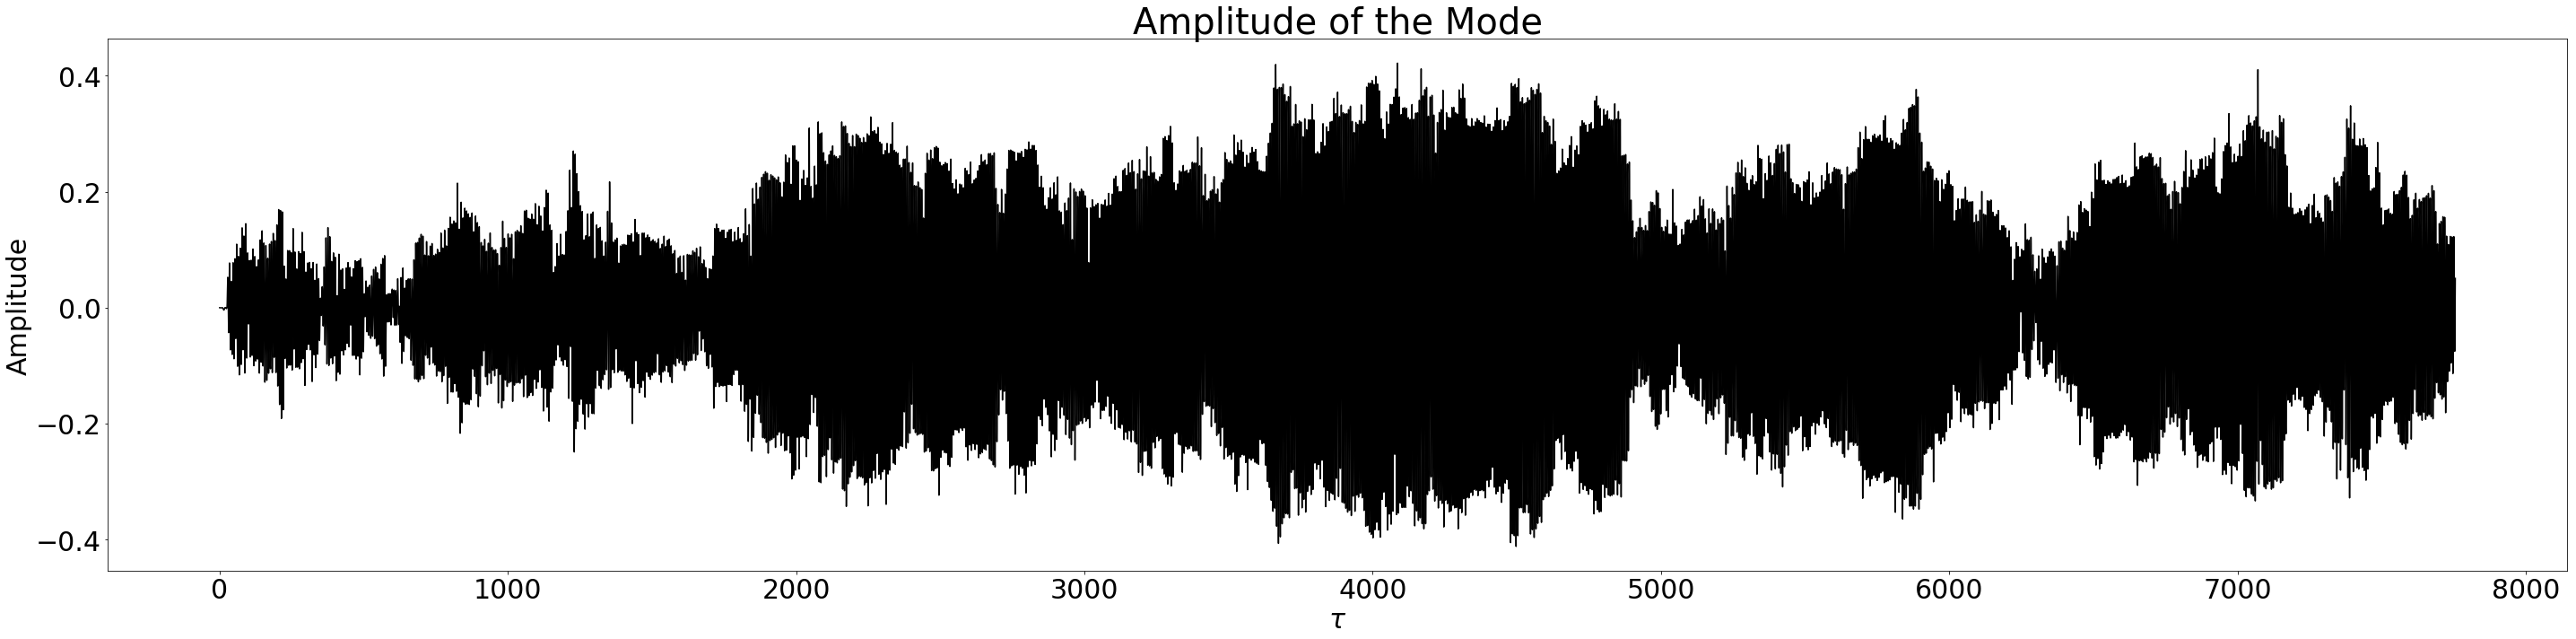

dTau = 2 * pi / 25.0


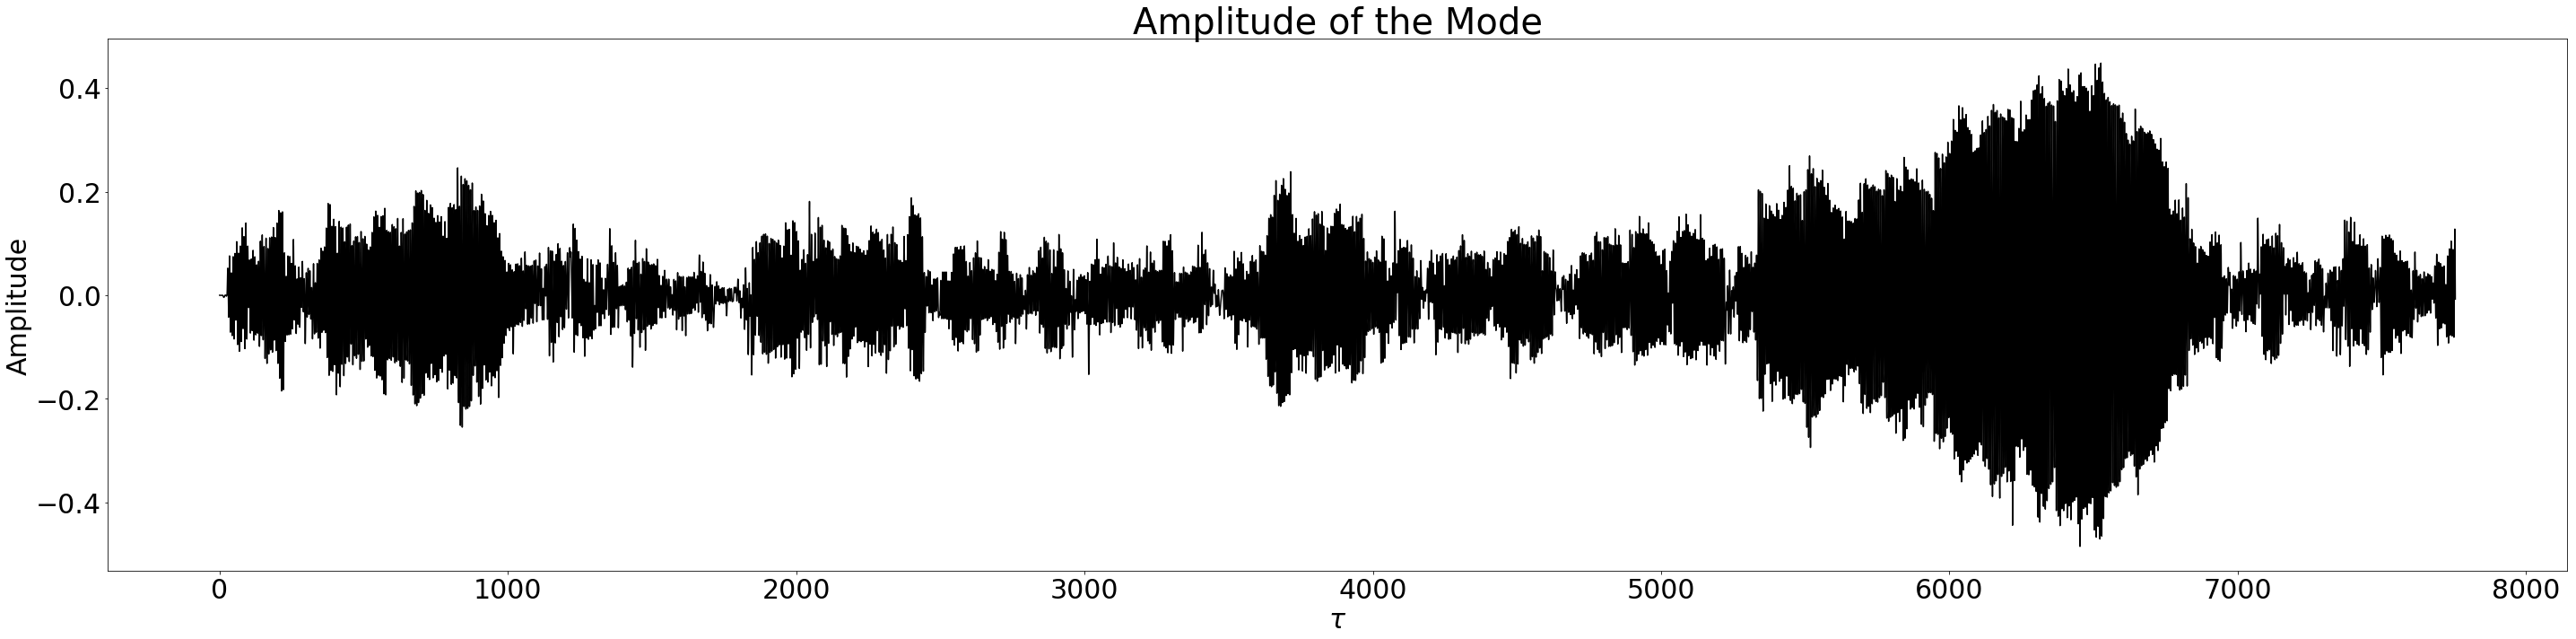

dTau = 2 * pi / 12.5


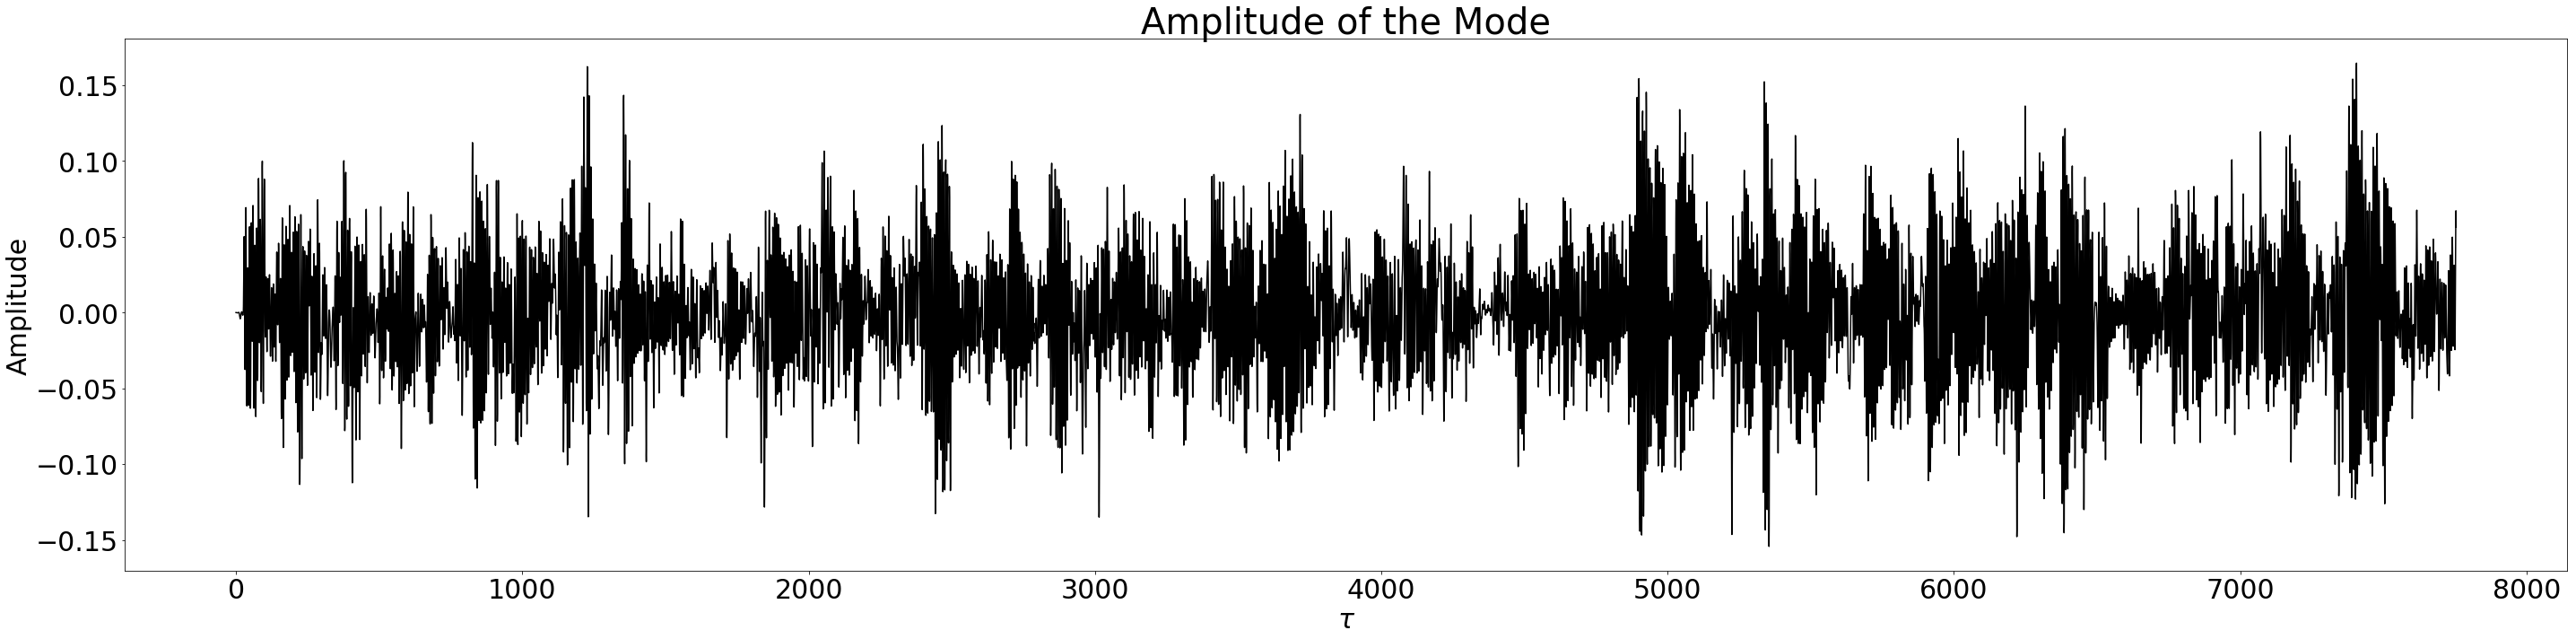

In [13]:
J = J_initial

while J > 12:
    
    print("dTau = 2 * pi /", J)
    
    dTau = fundTau(J)
    
    amptime = []
    Amp, amptime = funAmp(F1, F2, G1, dTau)

    plt.figure(figsize=(40,10))
    plt.plot(amptime, Amp, 'k')
    plt.title('Amplitude of the Mode', **title_font)
    plt.xticks(fontsize=30)
    plt.yticks(fontsize=30)
    plt.xlabel(r'$\tau$', **axis_font)
    plt.ylabel('Amplitude', **axis_font)
    plt.tight_layout()
    plt.show()
    
    J = J / 2